## Convolution Neural Network for image classification

Problem Statement: This is an image classification problem. The task is to classify images as Cat or Dog, hence Binary classification.

Solution: This can be reloved using Deep Learning techniques. Lets try with Convolutional Neural Network with Augmentation

## Import Libraries

In [1]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout,Flatten, Conv2D,RandomContrast ,RandomFlip,RandomRotation, RandomZoom, RandomHeight, RandomWidth,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

## Load Data

The Data is in zip file format, therefore unzip and load data into dataframes

In [2]:
os.listdir('./kaggle/input/dogs-vs-cats')

['sampleSubmission.csv', 'test1.zip', 'train.zip']

In [3]:
train_data = './kaggle/input/dogs-vs-cats/train.zip'
test_data = './kaggle/input/dogs-vs-cats/test1.zip'

files = './kaggle/working/'

import zipfile

with zipfile.ZipFile(train_data,'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_data,'r') as zipp:
    zipp.extractall(files)

In [4]:
os.listdir('./kaggle/working')

['test1', 'train']

## Splitting

Splitting the name for files and creating a target label as Dog or Cat

In [5]:
filenames = os.listdir('/kaggle/working/train/')
labels = [file_name.split(".")[0] for file_name in filenames]

In [6]:
df_train = pd.DataFrame({'Filenames':filenames,'Label':labels})
df_train.head(5)

,Filenames,Label
0,cat.1613.jpg,cat
1,dog.11648.jpg,dog
2,dog.5982.jpg,dog
3,dog.10328.jpg,dog
4,cat.3323.jpg,cat


## Sample
Taking only 2000 images as data is huge

In [7]:
df_train = df_train.iloc[:2000,:]
df_train_copy =  df_train.iloc[:2000,:]

## Target Balance
The Balance is more or less 50% each, hence its good for modeling

In [8]:
df_train['Label'].value_counts()

Label
cat    1043
dog     957
Name: count, dtype: int64

## Load Test Data Set

In [9]:
filenames = os.listdir('/kaggle/working/test1')
labels = [file_name.split(".")[0] for file_name in filenames]

In [10]:
df_test = pd.DataFrame({'Filenames':filenames,'Label':labels})
df_test.head(5)

,Filenames,Label
0,170.jpg,170
1,3386.jpg,3386
2,6924.jpg,6924
3,4547.jpg,4547
4,8108.jpg,8108


## Visualize Sample Images

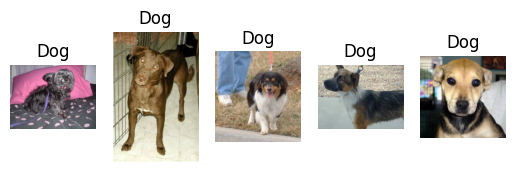

In [11]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title('Cat')
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog')
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)    
    plt.axis('off')

## Train Test Split Data

Here we use Y not as an array but as labeling the class using stratify.

From Sklearn, stratify : array-like, default=None, If not None, data is split in a stratified fashion, using this as the class labels

In [12]:
X= df_train['Filenames']
y= df_train['Label']
X_train,X_Val = train_test_split(df_train,stratify=y,test_size=0.2,random_state=42)

## Generate Images

Keras ImageDataGenerator is a very powerful library which not only helps in image generation but also image augumentation

In [13]:
train_dg = ImageDataGenerator(rescale = 1./255)
validate_dg = ImageDataGenerator(rescale = 1./255)

## Define images generated in Train, Validate and Test

In [14]:
train_g = train_dg.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32)
validate_g = validate_dg.flow_from_dataframe(dataframe = X_Val,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32,shuffle=False)
test_g = validate_dg.flow_from_dataframe(dataframe = df_test,directory='test1/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,class_mode=None,
                                       target_size=(128,128),batch_size=32,
                                       shuffle=False)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


## Model 1

Adding Augmentation Layer within CNN Model from layers

## Visualize different Image Augmentation

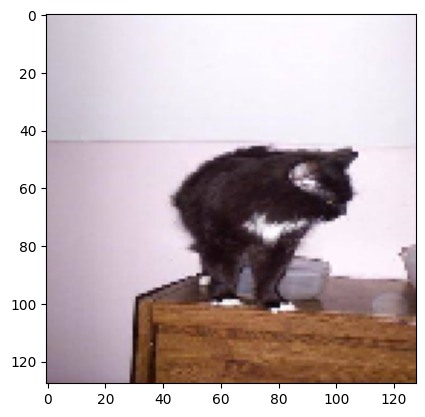

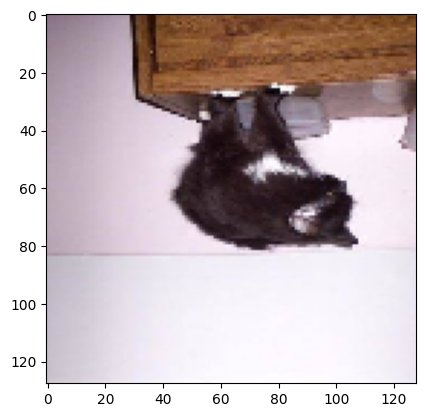

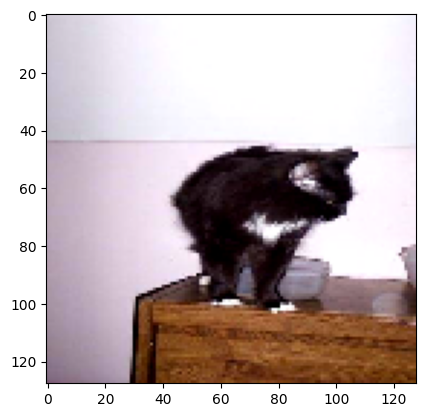

In [15]:
images, labels = next(train_g)
img = images[2]
plt.imshow(img)
plt.show()

random_flip = RandomFlip("horizontal_and_vertical")
flipped_image = random_flip(img)
plt.imshow(flipped_image)
plt.show()

random_contrast = RandomContrast(factor=0.90)
image_contrast = random_contrast(img)
plt.imshow(image_contrast)
plt.show()

### Define Layers

In [16]:
cnn_model = Sequential()

# Input Layer
cnn_model.add(Conv2D(32,kernel_size=(3,3),activation = 'relu'
                     ,input_shape=(128,128,3)))
cnn_model.add(MaxPooling2D(2,2))

# Augumentation Layer
cnn_model.add(RandomRotation(0.2))
cnn_model.add(RandomZoom(0.2))
cnn_model.add(RandomFlip("horizontal_and_vertical"))
cnn_model.add(RandomContrast(factor=0.90))

# Hidden Layers
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(254,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

# Output Layer
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(Dense(2,activation='softmax'))

cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 63, 63, 32)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 63, 63, 32)     │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 254)    │       292,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 254)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 254)      │         1,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,682,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,071,288 (19.35 MB)

 Trainable params: 5,070,332 (19.34 MB)

 Non-trainable params: 956 (3.73 KB)

### Compile

In [17]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Callback

In [18]:
early_stoping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=0)

### Fit

In [19]:
history = cnn_model.fit(train_g,epochs=20,validation_data=validate_g,batch_size = 32,callbacks=[early_stoping])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 876ms/step - accuracy: 0.5592 - loss: 2.7156 - val_accuracy: 0.5400 - val_loss: 1.1358
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 869ms/step - accuracy: 0.5758 - loss: 2.0966 - val_accuracy: 0.4775 - val_loss: 1.5076
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 874ms/step - accuracy: 0.5953 - loss: 1.3980 - val_accuracy: 0.5275 - val_loss: 1.2772
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 868ms/step - accuracy: 0.6084 - loss: 1.0363 - val_accuracy: 0.5225 - val_loss: 1.3113
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 884ms/step - accuracy: 0.6369 - loss: 0.8511 - val_accuracy: 0.5425 - val_loss: 0.8648
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 875ms/step - accuracy: 0.6481 - loss: 0.6790 - val_accuracy: 0.5900 - val_loss: 0.9606
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 871ms/step - accuracy: 0.6313 - loss: 0.6553 - val_accuracy: 0.5875 - val_loss: 0.7208
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 882ms/step - accuracy: 0.6653 - loss: 0.6154 - val_accuracy: 0.570

### Train Accuracy

In [20]:
loss,accuracy = cnn_model.evaluate(train_g,batch_size = 32, verbose = 0)
loss,accuracy 

(0.5520969033241272, 0.71875)

### Test Accuracy

In [21]:
loss,accuracy = cnn_model.evaluate(validate_g,batch_size = 32, verbose = 0)
loss,accuracy 

(0.6092463135719299, 0.6650000214576721)

### Prediction

In [22]:
pred = cnn_model.predict(validate_g,batch_size = 32)
y_pred = np.argmax(pred,axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step


## Model 2

Using ImageGenerator to Augment Images

### Different Types Image Augmenation

### 1. Flip

Found 1600 validated image filenames belonging to 2 classes.


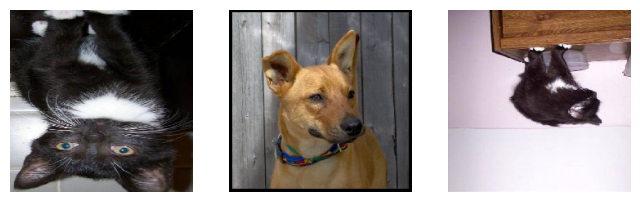

In [23]:
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### 2. Rotaion

Found 1600 validated image filenames belonging to 2 classes.


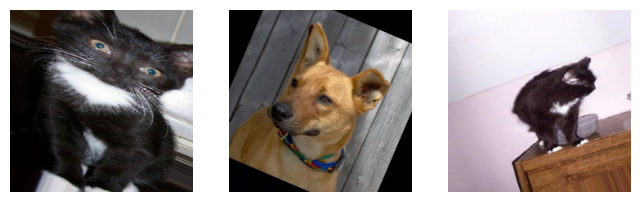

In [24]:
img_gen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### 3. Shift Image

Found 1600 validated image filenames belonging to 2 classes.


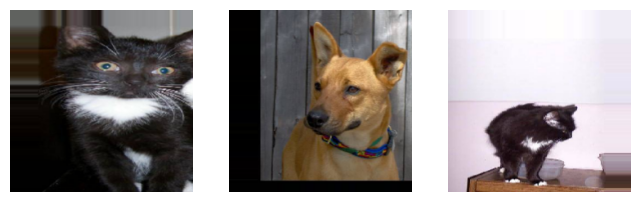

In [25]:
img_gen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### 4. Zoom

Found 1600 validated image filenames belonging to 2 classes.


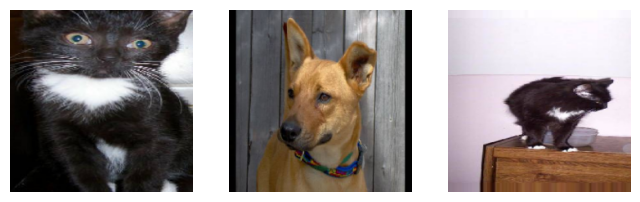

In [26]:
img_gen = ImageDataGenerator(zoom_range=0.2, shear_range = 0.1)

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### 5. Brightness

Found 1600 validated image filenames belonging to 2 classes.


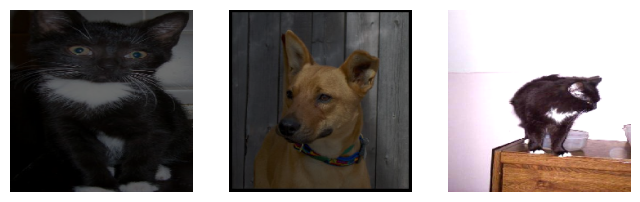

In [27]:
img_gen = ImageDataGenerator(brightness_range=[0.4,1.5])

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### 6. Flip

Found 1600 validated image filenames belonging to 2 classes.


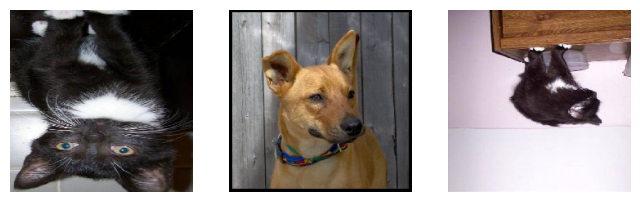

In [28]:
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

### Implement the augmentation techniques to the model

Image augmentation generates random images based on existing training data to improve the generalization ability of models

In [29]:
df_train = df_train_copy

In [30]:
X= df_train['Filenames']
y= df_train['Label']
X_train,X_Val = train_test_split(df_train,stratify=y,test_size=0.2,random_state=42)

In [31]:
X_train['Label'].value_counts(),X_Val['Label'].value_counts()

(Label
 cat    834
 dog    766
 Name: count, dtype: int64,
 Label
 cat    209
 dog    191
 Name: count, dtype: int64)

In [32]:
X_train.shape,X_Val.shape

((1600, 2), (400, 2))

In [33]:
# Augumentation 
train_dg = ImageDataGenerator(rescale = 1./25,
                            rotation_range = 30,
                            horizontal_flip = True,
                            zoom_range = 0.2,
                            shear_range = 0.1,
                            fill_mode = 'reflect', # Mirror image reflection of the image is used to fill new values of the pixel
                            width_shift_range = 0.2,
                            height_shift_range = 0.2)
validate_dg = ImageDataGenerator(rescale = 1./255)

In [34]:
train_g = train_dg.flow_from_dataframe(dataframe = X_train,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32)
validate_g = validate_dg.flow_from_dataframe(dataframe = X_Val,directory='train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32,shuffle=False)
test_g = validate_dg.flow_from_dataframe(dataframe = df_test,directory='test1/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,class_mode=None,
                                       target_size=(128,128),batch_size=32,
                                       shuffle=False)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Define Layers

In [35]:
cnn_model = Sequential()

# Input Layer
cnn_model.add(Conv2D(32,kernel_size=(3,3),activation = 'relu'
                     ,input_shape=(128,128,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.2))

# Hidden Layers
cnn_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(254,kernel_size=(3,3),activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.2))

# Fully Connected layers
cnn_model.add(Flatten())
cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.2))

# Output Layer
cnn_model.add(Dense(2,activation='softmax'))

cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 254)    │       292,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 254)    │         1,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 254)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 254)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,682,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,073,336 (19.35 MB)

 Trainable params: 5,071,356 (19.35 MB)

 Non-trainable params: 1,980 (7.73 KB)

### Compile

In [36]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Callbacks

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

### Fit

In [38]:
history = cnn_model.fit(train_g,epochs=20,validation_data=validate_g,batch_size = 32, callbacks=[early_stoping,learning_rate_reduction])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 991ms/step - accuracy: 0.5827 - loss: 1.0438 - val_accuracy: 0.5525 - val_loss: 0.8793 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 971ms/step - accuracy: 0.5844 - loss: 0.7530 - val_accuracy: 0.5225 - val_loss: 1.1321 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.5861 - loss: 0.7242
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 962ms/step - accuracy: 0.5862 - loss: 0.7242 - val_accuracy: 0.5225 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 982ms/step - accuracy: 0.6308 - loss: 0.6868 - val_accuracy: 0.5225 - val_loss: 1.0367 - learning_rate: 5.0000e-04


### Train and Test Accuracy

In [39]:
loss,accuracy = cnn_model.evaluate(train_g,batch_size = 32, verbose = 0)
loss,accuracy 

(1.5580291748046875, 0.5206249952316284)

In [40]:
loss,accuracy = cnn_model.evaluate(validate_g,batch_size = 32, verbose = 0)
loss,accuracy 

(0.8792693614959717, 0.5525000095367432)

### Predict

In [41]:
pred = cnn_model.predict(validate_g,batch_size = 32,verbose = 0)
y_pred = np.argmax(pred,axis=1)

In [42]:
y_true= validate_g.labels

In [43]:
labels = ['Cat','Dog']
print(classification_report(y_true,y_pred,target_names= labels))

              precision    recall  f1-score   support

         Cat       0.56      0.66      0.61       209
         Dog       0.54      0.43      0.48       191

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.54       400
weighted avg       0.55      0.55      0.55       400



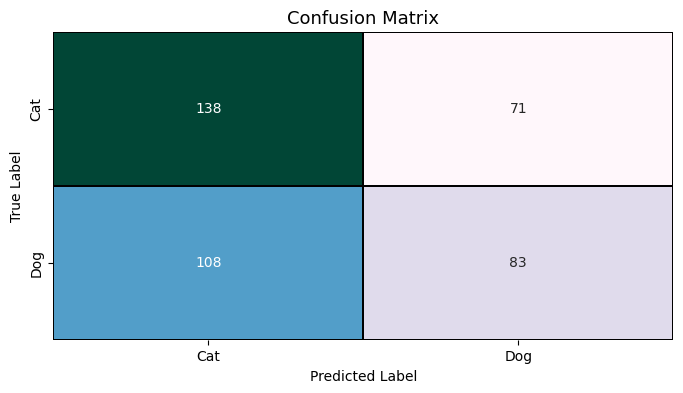

In [44]:
confusion_mtx = confusion_matrix(y_true,y_pred) 

fig,ax = plt.subplots(figsize = (8,4) )
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "PuBuGn",
            linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

### References

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/